### Twitter Hate Speech Analysis
When working on a supervised machine learning problem with a given data set, we try different algorithms and techniques to search for models to produce general hypotheses, which then make the most accurate predictions possible about future instances. The same principles apply to text (or document) classification where there are many models can be used to train a text classifier. 

We are going tp train multiple models to compare and decide which one is the best model.

### The Data
The data we are using from twitter.The data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [6]:
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit
import gensim
import re
import logging
import string
from numpy import random
from bs4 import BeautifulSoup

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import SnowballStemmer                 # Stemmer
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec  

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline



#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [7]:
df = pd.read_csv('labeled_data.csv')
#df = df[pd.notnull(df['class'])]
#df = df.head(5000)
print(df.head(10))
print(df['tweet'].apply(lambda x: len(x.split(' '))).sum())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   
5           5      3            1                   2        0      1   
6           6      3            0                   3        0      1   
7           7      3            0                   3        0      1   
8           8      3            0                   3        0      1   
9           9      3            1                   2        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Da

We have over 3 million words in. tweets

Text(0,0.5,'tweet count')

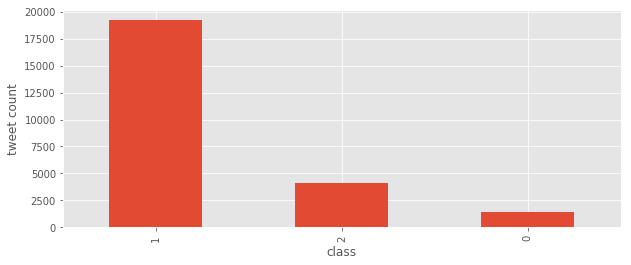

In [8]:
# Shape of our data
df.columns
df.head(10)
plt.figure(figsize=(10,4))
ax=df['class'].value_counts().plot(kind='bar');
ax.set_xlabel("class")
ax.set_ylabel("tweet count")

In [9]:
#0 - hate speech 1 - offensive language 2 - neither
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [10]:
df['class']=[1 if b == 2 else 0 for b in df['class']] # merged the 0-hate speech 1-offensive language into 1 and neither into 0
# Transform into binary classification
#df['class'] = [1 if b == 2 else 0 for b in df['class']]
df['class'].value_counts()

0    20620
1     4163
Name: class, dtype: int64

Text(0,0.5,'count')

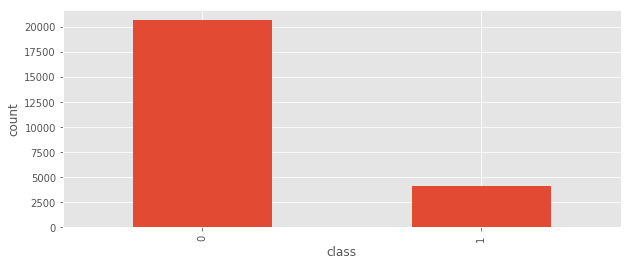

In [11]:
# Shape of our data
df.columns
df.head(10)
plt.figure(figsize=(10,4))
ax=df['class'].value_counts().plot(kind='bar');
ax.set_xlabel("class")
ax.set_ylabel("count")

### Text Pre-processing
The text cleaning techniques we have seen so far work very well in practice. Depending on the kind of texts you may encounter, it may be relevant to include more complex text cleaning steps. But keep in mind that the more steps we add, the longer the text cleaning will take.
For this particular data set, our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [12]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", "", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text
# apply the above function to df['tweet']
df['tweet'] = df['tweet'].map(lambda x: clean_text(x))
    
#df['tweet'] = df['tweet'].apply(clean_text)
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,mayasolov : woman complain clean hous amp; man...
1,1,3,0,3,0,0,mleew17 : boy dat cold tyga dwn bad cuffin dat...
2,2,3,0,3,0,0,urkindofbrand dawg 80sbaby4lif : ever fuck bit...
3,3,3,0,2,1,0,c g anderson : viva base look like tranni
4,4,6,0,6,0,0,shenikarobert : shit hear might true might fak...
5,5,3,1,2,0,0,t madison x : shit blow me claim faith somebod...
6,6,3,0,3,0,0,brighterday : sit hate anoth bitch got much sh...
7,7,3,0,3,0,0,8220; selfiequeenbri : caus i am tire big bitc...
8,8,3,0,3,0,0,amp; might get bitch back amp; that
9,9,3,1,2,0,0,rhythmixx : hobbi includ : fight mariam + + bitch


In [13]:
df['tweet'].apply(lambda x: len(x.split(' '))).sum()

260349

After text cleaning and removing stop words, we have only over 2 million words to work with!
After splitting the data set, the next steps includes feature engineering. 
We will convert our text documents to a matrix of token counts (CountVectorizer).

### Preparing for Training
Before training, and even vectorizing, let's split our data into training and testing sets. It's important to do this before doing anything with the data so we have a fresh test set.

In [14]:
from sklearn.model_selection import train_test_split

X = df['tweet'] # predictor
y = df['class'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Our test size is 0.2, or 20%. This means that X_test and y_test contains 20% of our data which we reserve for testing.

Let's now fit the vectorizer on the training set only and perform the vectorization.

Just to reiterate, it's important to not fit the vectorizer on all of the data since we want a clean test set for evaluating performance. Fitting the vectorizer on everything would result in data leakage, causing unreliable results since the vectorizer shouldn't know about future data.

### Tokenize 
Tokenization of sentences is one of the essential parts in natural language processing. Tokenization simply divides a sentence into a list of words. After text cleaning and removing stop words, we have only over 2 million words to work with! We will convert our text documents to a matrix of token counts using the CountVectorizer to tokenize (CountVectorizer).

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=24783,binary=True)
corpus = df['tweet']

X= vectorizer.fit_transform(corpus)

features = vectorizer.get_feature_names()

#print('features',features)

vocab = vectorizer.vocabulary_
#print('Vocab',vocab)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

#vect is set up with default params to tokenize and lowercase words. On top of that, we have set binary=True so we get an output of 0 (word doesn't exist in that sentence) or 1 (word exists in that sentence).

#vect builds a vocabulary from all the words it sees in all the text you give it, then assigns a 0 or 1 if that word exists in the current sentence. 

vect = CountVectorizer(max_features=24783,binary=True)

X_train_vect = vect.fit_transform(X_train)

features = vectorizer.get_feature_names()

#print('features',features)

vocab = vectorizer.vocabulary_
#print('Vocab',vocab)


X_train_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
#To see this more clearly, let's check out the feature names mapped to the first sentence:
list(zip(X_train_vect.toarray()[0], vect.get_feature_names()))

[(0, '00'),
 (0, '000'),
 (0, '0000000000000'),
 (0, '0000karen'),
 (0, '0000vf0rewjd'),
 (0, '003'),
 (0, '007m'),
 (0, '00am'),
 (0, '00pm'),
 (0, '00sexilexi00'),
 (0, '0124jessi'),
 (0, '012llzcmsu'),
 (0, '01takesthelead'),
 (0, '01vjzqnahh'),
 (0, '02'),
 (0, '0221'),
 (0, '02e1ceoe3z'),
 (0, '03'),
 (0, '0300'),
 (0, '03as6bgqec'),
 (0, '03otpzxcbi'),
 (0, '03pgoqqji'),
 (0, '03s8desezq'),
 (0, '03sohp4p41'),
 (0, '04'),
 (0, '05'),
 (0, '05235fd083ad408'),
 (0, '05professor'),
 (0, '06'),
 (0, '060glx19or'),
 (0, '06e77bgwbx'),
 (0, '06olvik6ld'),
 (0, '07'),
 (0, '0723'),
 (0, '07cannon'),
 (0, '08'),
 (0, '08cqv2vccx'),
 (0, '09'),
 (0, '0a2dy3vzkm'),
 (0, '0b0pz8j4cm'),
 (0, '0beythelau'),
 (0, '0beyyourmast'),
 (0, '0biwankob'),
 (0, '0ddment'),
 (0, '0ddtoddler'),
 (0, '0dvazwlq2q'),
 (0, '0g1j8bibpl'),
 (0, '0gexxj3svv'),
 (0, '0hallis0n'),
 (0, '0idy5oskrf'),
 (0, '0iex8q4wml'),
 (0, '0inch'),
 (0, '0injjm374v'),
 (0, '0j96w8ofmq'),
 (0, '0lrdpized0'),
 (0, '0malbndkn9')

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

#vect is set up with default params to tokenize and lowercase words. On top of that, we have set binary=True so we get an output of 0 (word doesn't exist in that sentence) or 1 (word exists in that sentence).

#vect builds a vocabulary from all the words it sees in all the text you give it, then assigns a 0 or 1 if that word exists in the current sentence. 

vect = CountVectorizer(max_features=24783,binary=True)

X_train_vect = vect.fit_transform(X_train)

features = vectorizer.get_feature_names()

#print('features',features)

vocab = vectorizer.vocabulary_
#print('Vocab',vocab)


In [21]:
print(type(X_train_vect))


X_train_vect.toarray()

<class 'scipy.sparse.csr.csr_matrix'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create the transform
vect = TfidfVectorizer()
# tokenize and build vocab
X_train_vect = vect.fit(X_train)
# summarize
print(vect.vocabulary_)
print(vect.idf_)
# encode document
vector = vect.transform([X_train[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'shawti': 20983, 'bitch': 3466, 'one': 17491, 'get': 9513, 'money': 15968, 'wid': 25803, 'quick': 19126, 'piec': 18258, 'pussi': 18968, 'call': 4484, 'drive': 7403, 'femshaveballz': 8534, 'looter': 14566, 'ferguson': 8545, 'retard': 19732, 'risk': 19925, 'arrest': 2343, 'free': 8984, 'food': 8835, 'ebt': 7687, 'alreadi': 1937, 'pay': 17997, 'lo': 14483, '8230': 1231, 'cashoutmolli': 4689, 'stupid': 22372, 'cheat': 4965, 'man': 15037, 'wanna': 25350, 'fight': 8589, 'girl': 9618, 'leav': 13968, 'nigga': 16816, 'move': 16110, 'nogoodnigg': 16959, 'stop': 22267, 'gass': 9397, 'regular': 19602, 'ass': 2443, 'saulsof1lthi': 20494, 'boi': 3735, 'kayliefarm': 13079, 'bbluedreamm': 3036, 'dare': 6375, 'will': 25837, 'slay': 21448, 'fruiti': 9080, 'quaf': 19073, 'tranni': 23951, 'macmil': 14899, 'lucki': 14721, 'ft': 9089, 'juici': 12793, 'rottenstench': 20127, 'tank': 22774, 'lot': 14595, 'mr': 16124, 'pube': 18892, 'love': 14620, 'uncl': 24577, 'tom': 23758, 'pic': 18242, 'confus': 5657, 'loo

### Balancing the Data
It seems that there may be a lot more negative tweets than positive tweets, and so we have a lot more negative labels than positive labels.



In [11]:
counts = df['class'].value_counts()
print(counts)

print("\nPredicting only 0 = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))

0    20620
1     4163
Name: class, dtype: int64

Predicting only 0 = 83.20% accuracy


We can see from above, we have  more negatives than positives, making our dataset clearly imbalanced.

By calculating if our model only chose to predict 0(hate and offensive language), the larger class, we would get a ~60% accuracy. This means that in our binary classification model, where random chance is 50%, a 60% accuracy wouldn't tell us much. We would definitely want to look at precision and recall more than accuracy.

We can balance our data by using a form of oversampling called SMOTE. SMOTE looks at the minor class, neutrals in our case, and creates new, synthetic training examples. 

Let's perform SMOTE with the imblearn library:

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

# X_train_res, y_train_res are balanced datasets
X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [13]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 16516), (1, 16516)]


### Bagging

Now the data is balanced we can perform ensemble learning

In [108]:
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
  


In [109]:
#descision tree
dt = DecisionTreeClassifier()
dt.fit(X_train_res,y_train_res)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [115]:
X_test_vect = vect.transform(X_test)
predictions = dt.predict(X_test_vect)
#precision, recall, fscore, support = score(y_test, predictions, average='macro')

print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))







[[3826  278]
 [  79  774]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      4104
           1       0.74      0.91      0.81       853

   micro avg       0.93      0.93      0.93      4957
   macro avg       0.86      0.92      0.88      4957
weighted avg       0.94      0.93      0.93      4957

0.9279806334476498


In [116]:
dt.score(X_train_res,y_train_res)

0.9996367159118431

In [117]:
#Random Forest 

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
X_test_vect = vect.transform(X_test)
predictions = rf.predict(X_test_vect)
print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))



[[3887  217]
 [ 221  632]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4104
           1       0.74      0.74      0.74       853

   micro avg       0.91      0.91      0.91      4957
   macro avg       0.85      0.84      0.84      4957
weighted avg       0.91      0.91      0.91      4957

0.9116401049021585


In [99]:
rf.score(X_train_res,y_train_res)

0.9989404214095423

In [100]:
#Bagging 

bg = BaggingClassifier(DecisionTreeClassifier(), max_samples= 0.5, max_features = 1.0, n_estimators = 20)
bg.fit(X_train_res,y_train_res)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.5, n_estimators=20, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [119]:
X_test_vect = vect.transform(X_test)
predictions = bg.predict(X_test_vect)
print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))



[[3799  305]
 [  40  813]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4104
           1       0.73      0.95      0.82       853

   micro avg       0.93      0.93      0.93      4957
   macro avg       0.86      0.94      0.89      4957
weighted avg       0.94      0.93      0.93      4957

0.9304014524914263


In [120]:
bg.score(X_train_res,y_train_res)

0.9819568902882054

In [121]:
#Boosting - Ada Boost

adb = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators = 5, learning_rate = 1)
adb.fit(X_train_res,y_train_res)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=5, random_state=None)

In [122]:
X_test_vect = vect.transform(X_test)
predictions = adb.predict(X_test_vect)

print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))



[[3780  324]
 [  60  793]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4104
           1       0.71      0.93      0.81       853

   micro avg       0.92      0.92      0.92      4957
   macro avg       0.85      0.93      0.88      4957
weighted avg       0.94      0.92      0.93      4957

0.9225337905991527


In [123]:
adb.score(X_train_res,y_train_res)

0.9996367159118431

### Voting Classifiers
After we evaluated each classifier individually, let's see if ensembling helps improve our metrics.

We're going to use sklearn's VotingClassifier which defaults to a majority rule voting.

Note: Instead of stacking classifier we have used voting classifiers

In [77]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


X = df['tweet']
y = df['class']

cv = ShuffleSplit(n_splits=10, test_size=0.2)

models = [
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(),
    RandomForestClassifier(),
    
]


m_names = [m.__class__.__name__ for m in models]

models = list(zip(m_names, models))
vc = VotingClassifier(estimators=models)


sm = SMOTE()

# No need for dictionary now
accs = []
f1s = []
cms = []

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    vc.fit(X_train_res, y_train_res)
    
    y_pred = vc.predict(X_test_vect)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
print("Voting Classifier")
print("-" * 30)
print("Avg. Accuracy: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Avg. F1 Score: {:.2f}".format(sum(f1s) / len(f1s) * 100))
print("Confusion Matrix:\n", sum(cms) / len(cms))


Voting Classifier
------------------------------
Avg. Accuracy: 94.38%
Avg. F1 Score: 82.45
Confusion Matrix:
 [[4024.2   97.6]
 [ 180.8  654.4]]


### Conclusion and further precursor
So far we've

- Mined data from twitter
- Obtained  scores for tweets
- cleaned the data
- Vectorized the data
- Run the data through several types of models
- Ensembled models together
Unfortunately, there isn't an obvious winning model. There's a couple we've seen that definitely perform poorly, but there's a few that hover around the same accuracy. 

We have seen  how this pipeline works, there's a lot of room for improvement on the architecture of the code and modeling. 